# Проект для спецкурса "Введение в анализ медицинских изображний"

[Соревнование](https://www.kaggle.com/competitions/iamisegmentation/overview) на kaggle

Код для считывания и сохранения изображений уже был написан, мною реализовано увеличение количества данных с помощью применения аффинных преобразований изображения (cell 6), а также сама сеть (cells 9-11). Выбрана была модификация Unet со слоями Dropout и Batch Normalization с обучением на 35\*10 (35 исходных) изображениях и валидацией на 5 оставшихся. Количество эпох - 20. (Пяти оказалось слишком мало, на двадцати сеть училась 2 дня, поэтому было решено остановиться на данном результате).

Источники:

1. https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

2. https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/

3. https://python-school.ru/blog/affine-transformation/

### 1. Библиотеки

In [1]:
import numpy as np
import pydicom as dc
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import tensorflow as tf
import keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers

### 2. Считывание Train/Test в Numpy массивы
1) Изображения записаны в формате ***dicom***. Для их чтения используем специальную библиотеку *pydicom*

2) В разметке имеется всего 4 класса: 
* 0 - фон, 
* 1 - висцеральный жир, кости, органы
* 2 - мышцы и внутримышечный жир, кости
* 3 - подкожный жир


In [2]:
train_names = sorted(glob('./train/DICOM/*'))
test_names = sorted(glob('./test/DICOM/*'))
label_names = sorted(glob('./train/Label/*'))

train_ds = []
test_ds = []
y_train_1 = []

for name in train_names:
    train_ds.append(dc.dcmread(name))
for name in test_names:
    test_ds.append(dc.dcmread(name))
for label_name in label_names:
    img = Image.open(label_name)
    y_train_1.append(np.asarray(img))
y_train_1 = np.asarray(y_train_1)

In [3]:
X_train_1 = []
X_test = []
for sample_ds in train_ds:
    X_train_1.append(sample_ds.pixel_array)
for sample_ds in test_ds:
    X_test.append(sample_ds.pixel_array)
X_train_1 = np.asarray(X_train_1).astype(float)
X_test = np.asarray(X_test).astype(float)

In [4]:
X_test.shape, X_train_1.shape

((20, 512, 512), (40, 512, 512))

In [5]:
X_test.min(), X_test.max()

(-1024.0, 1324.0)

In [6]:
import random as random
from tensorflow.keras.preprocessing.image import apply_affine_transform
def rand(x, delta):
    y = x + random.random() * delta
    return(y)
X_new = X_train_1[:,:,:,np.newaxis]
y_new = y_train_1[:,:,:,np.newaxis]
X_train = []
y_train = []
for i in range(40):
    X_train.append(X_train_1[i])
    y_train.append(y_train_1[i])
    if(i < 35):
        for j in range(9):
            param = [rand(-3.0, 6.0), rand(-5.0, 10.0), rand(-5., 10.), rand(0.9, 0.2), rand(0.9, 0.2)]
            X_train.append(apply_affine_transform(X_new[i], theta=param[0], tx=param[1], ty=param[2],zx=param[3], zy=param[4])[:,:,0])
            y_train.append(apply_affine_transform(y_new[i], theta=param[0], tx=param[1], ty=param[2],zx=param[3], zy=param[4])[:,:,0])
X_train = np.asarray(X_train).astype(float)
y_train = np.asarray(y_train).astype(int)
print(X_test.shape, X_train.shape)

(20, 512, 512) (355, 512, 512)


### 3. Визуализация данных

##### 3.1. Семплы и их разметка

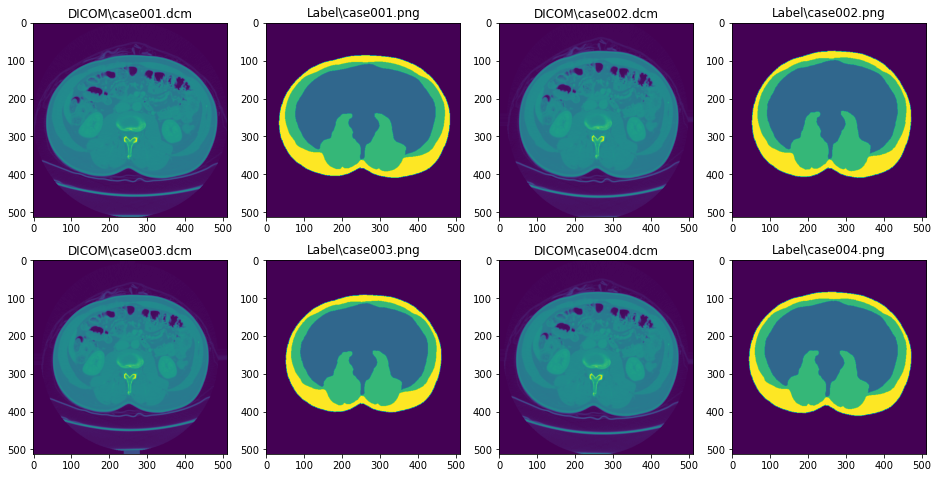

In [7]:
nrows, ncols = 2, 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_figheight(8), fig.set_figwidth(8 * ncols // nrows)
for i, (X, y) in enumerate(zip(X_train, y_train)):
    if i == nrows * ncols // 2:
        break
    ax[2 * i // ncols, 2 * i % ncols].imshow(X)
    ax[2 * i // ncols, 2 * i % ncols].set_title(f"{train_names[i].split('/')[-1]}")
    ax[(2 * i + 1) // ncols, (2 * i + 1) % ncols].imshow(y)
    ax[(2 * i + 1) // ncols, (2 * i + 1) % ncols].set_title(f"{label_names[i].split('/')[-1]}")

##### 3.2. Один из семплов в ЧБ формате 

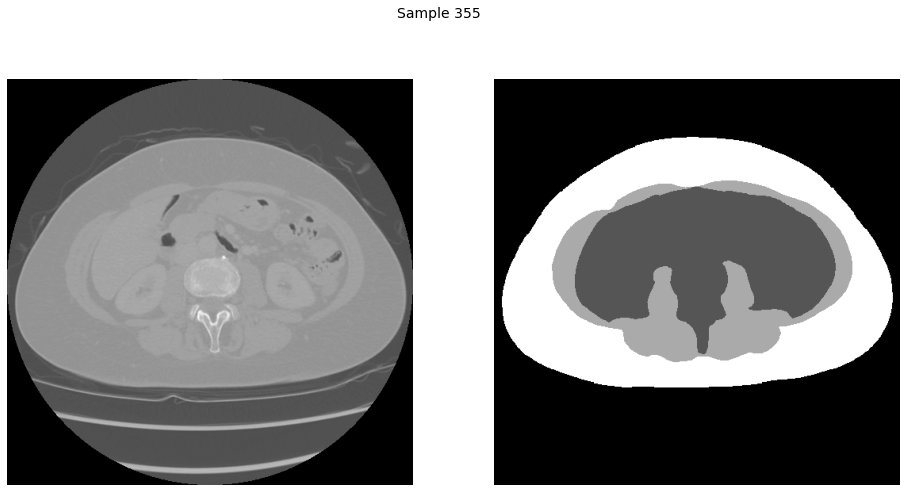

In [8]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8), fig.set_figwidth(16)
fig.suptitle(f'Sample {X_train.shape[0]}', fontsize=14)
ax[0].imshow(X_train[-1], cmap='gray')
ax[0].axis('off'), ax[1].axis('off')
_ = ax[1].imshow(y_train[-1], cmap='gray')

### 4. Алгоритм для Сегментации
Предлагается реализовать алгоритм для сегментации мышц и жира на снимках КТ на основе глубинного машинного обучения.

In [9]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    up = layers.Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)    
    merge = layers.Concatenate()([up, skip_layer_input])
    conv = layers.Conv2D(n_filters, 
                  3,  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(merge)
    conv = layers.Conv2D(n_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    conv = layers.BatchNormalization()(conv, training=False)  
    conv = layers.LeakyReLU()(conv)
    return conv

def EncoderMiniBlock(inputs, n_filters=32, second_conv = 1):
    conv = layers.Conv2D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    if(second_conv):
        conv = layers.Conv2D(n_filters, 
                             3,  # filter size
                             activation='relu',
                             padding='same',
                             kernel_initializer='HeNormal')(conv)
    conv = layers.BatchNormalization()(conv, training=False)  
    conv = layers.LeakyReLU()(conv)
    return conv


# U-Net
def build_net(input_shape):
    inputs = layers.Input(input_shape)
    # Contruction
    s0= EncoderMiniBlock(inputs, 64, second_conv = 0)
    s1 = EncoderMiniBlock(inputs, 64, second_conv = 0)
    p1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(s1)
    s2= EncoderMiniBlock(p1,128)
    p2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(s2)
    s3= EncoderMiniBlock(p2, 256)
    p3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(s3)
    s4= EncoderMiniBlock(p3, 512)
    p4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(s4)

    b0 = EncoderMiniBlock(p4, 1024)
    b1 = tf.keras.layers.Dropout(0.3)(b0)
    
    # Expansion
    d1 = DecoderMiniBlock(b1, s4, 512)
    d2 = DecoderMiniBlock(d1, s3, 256)
    d3 = DecoderMiniBlock(d2, s2, 128)
    d4 = DecoderMiniBlock(d3, s1, 64)

    outputs = layers.Conv2D(4, (1,1), padding="same", activation="softmax")(d4)

    model = models.Model(inputs, outputs, name="U-Net_drop")
    return model

input_shape = (512, 512, 1)
model = build_net(input_shape)
#model.summary()

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
X_train_1 = X_train[:350]
y_train_1 = y_train[:350]
X_test_1 = X_train[350:]
test_masks = y_train[350:]
print(X_train_1.shape, X_test_1.shape)
results = model.fit(X_train_1, y_train_1, batch_size=5, epochs=20, validation_data = (X_test_1, test_masks))

(350, 512, 512) (5, 512, 512)
Epoch 1/20


D:\Python\dyak\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


70/70 [==============================] - 3593s 51s/step - loss: 90.6173 - accuracy: 0.6691 - val_loss: 6.2877 - val_accuracy: 0.6816
Epoch 2/20
70/70 [==============================] - 4187s 60s/step - loss: 3.1366 - accuracy: 0.8356 - val_loss: 1.6337 - val_accuracy: 0.8633
Epoch 3/20
70/70 [==============================] - 4426s 63s/step - loss: 0.6887 - accuracy: 0.9058 - val_loss: 1.0272 - val_accuracy: 0.8970
Epoch 4/20
70/70 [==============================] - 4434s 63s/step - loss: 0.3543 - accuracy: 0.9416 - val_loss: 0.8130 - val_accuracy: 0.9225
Epoch 5/20
70/70 [==============================] - 4452s 64s/step - loss: 0.2235 - accuracy: 0.9602 - val_loss: 0.7973 - val_accuracy: 0.9341
Epoch 6/20
70/70 [==============================] - 4428s 63s/step - loss: 0.1573 - accuracy: 0.9697 - val_loss: 0.9163 - val_accuracy: 0.9368
Epoch 7/20
70/70 [==============================] - 4422s 63s/step - loss: 0.1123 - accuracy: 0.9768 - val_loss: 0.4132 - val_accuracy: 0.9615
Epoch 8/2

In [11]:
def super_solution(test, net):
    y_test = (tf.argmax(net.predict(test, batch_size=4)[:], axis = -1)).numpy()
    return y_test

test_prediction = super_solution(X_test_1, model)
my_prediction = super_solution(X_test, model)

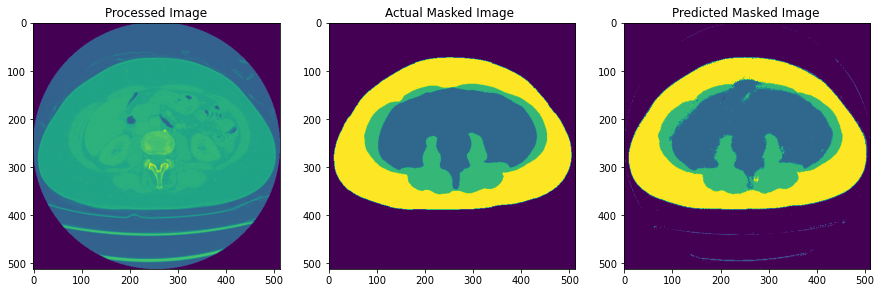

In [37]:
def VisualizeResults(index):
    img = X_test_1[index,0]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_test_1[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(test_masks[index])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(test_prediction[index])
    arr[2].set_title('Predicted Masked Image ')
VisualizeResults(4)

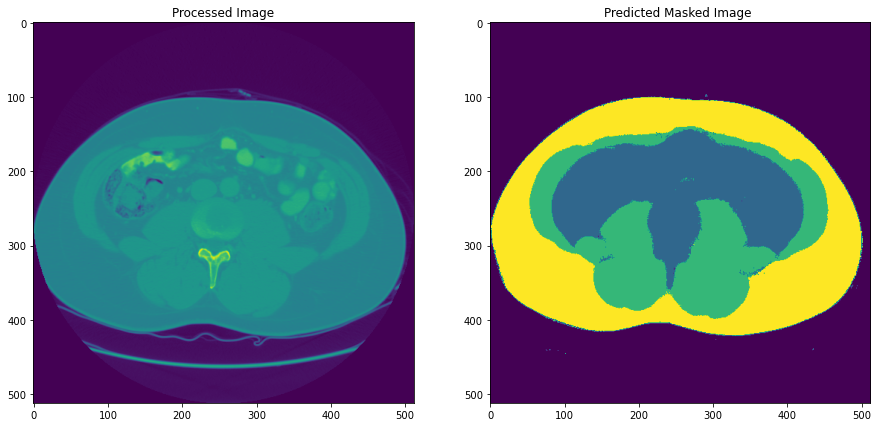

In [29]:
def VisualizeResults(index):
    img = X_test[index,0]
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X_test[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(my_prediction[index])
    arr[1].set_title('Predicted Masked Image ')
VisualizeResults(19)

In [13]:
model.save('U-Net,BN,D,20e,10x_im')

INFO:tensorflow:Assets written to: U-Net,BN,D,20e,10x_im\assets


### 5. DICE метрика
Для проверки своих результатов на валидации можно воспользоваться numpy версией **Dice loss** или взять заточенную под Ваш фреймворк функцию отсюда (не забудьте учесть, что в задаче не два класса):

[Метрики / Лоссы](https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch)

In [14]:
def one_hot_encode(arr, num_classes=4):
    return np.squeeze(np.eye(num_classes)[arr.reshape(-1)]).astype(np.uint8)


def dice(y_pred, y_true):
    gto = one_hot_encode(y_true)
    mo = one_hot_encode(y_pred)
    intersect = (gto * mo).sum()
    total = (gto + mo).sum()
    return np.mean(2. * intersect / (total + 1e-10))
y_val, y_pred = test_masks, test_prediction
dice(y_val, y_pred)

0.9736968994140625

### 6. Сохранение результатов на тестовой выборке
Сохраняем полученные маски в **csv** file

In [15]:
def rle_encoding(mask):
        dots = np.where(mask.T.flatten()==1)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1): run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths    


def write_submission(y):
    df = pd.DataFrame(columns=['ImageID', 'EncodedPixels'])
    for i, mask in enumerate(y):
        mask1 = (mask == 1).astype(int)
        mask2 = (mask == 2).astype(int)
        mask3 = (mask == 3).astype(int)
        df.loc[3 * i] = [str(3 * i), ""]
        df.loc[3 * i + 1] = [str(3 * i + 1), ""]
        df.loc[3 * i + 2] = [str(3 * i + 2), ""]
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask1)])
        df.loc[3 * i]['EncodedPixels'] = encoded_mask
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask2)])
        df.loc[3 * i + 1]['EncodedPixels'] = encoded_mask
        encoded_mask = ' '.join([str(val) for val in rle_encoding(mask3)])
        df.loc[3 * i + 2]['EncodedPixels'] = encoded_mask
    return df


df = write_submission(my_prediction)
df.to_csv('submission.csv', index=False)
df.shape

(60, 2)

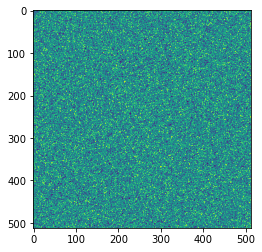

In [16]:
##Пример одной из масок, полученной с помощью super_solution функции
_ = plt.imshow(np.asarray(Image.open('./test/Label/case86.png')))

### 7. Возможно полезные ссылки для решения

1. [Tensorflow](https://www.tensorflow.org/)
2. [PyTorch](https://pytorch.org/)
3. [U-net](https://paperswithcode.com/method/u-net)
4. [Semantic Segmentation](https://paperswithcode.com/task/semantic-segmentation)
5. [Dice Loss](https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b)
6. [Pydicom](https://pydicom.github.io/)